In [1]:
from __future__ import print_function, division, unicode_literals
from io import open
import glob

In [6]:
import numpy as np

In [2]:
def findfiles(path):
    return glob.glob(path)

In [3]:
print(findfiles("./data/names/*.txt"))

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']


Deal with some character encodings now.

In [113]:
import unicodedata
import string

all_letters = string.ascii_letters + ",.;"
n_letters = len(all_letter)

In [114]:
blah = np.random.randint(0, n_letters)
all_letters[blah:blah+5]

'yzABC'

In [116]:
# Turn a Unicode string to plain ASCII
# thanks to http://stackoverflow.com/a/518232/2809427

def unicodeToAscii(s):
    return "".join(
    c for c in unicodedata.normalize("NFD", s)
    if unicodedata.category(c) != "Mn"
    and c in all_letters)

In [117]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [119]:
# Build the category_lines dictionary
# a list of names per language
category_lines = {}
all_categories = []

In [122]:
# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding="utf-8") as f:
        lines = f.read().strip().split("\n")
    return [unicodeToAscii(line) for line in lines]

In [124]:
for filename in findfiles("./data/names/*.txt"):
    category = filename.split("/")[-1].split(".")[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

In [125]:
category_lines.keys()

dict_keys(['names\\Arabic', 'names\\Chinese', 'names\\Czech', 'names\\Dutch', 'names\\English', 'names\\French', 'names\\German', 'names\\Greek', 'names\\Irish', 'names\\Italian', 'names\\Japanese', 'names\\Korean', 'names\\Polish', 'names\\Portuguese', 'names\\Russian', 'names\\Scottish', 'names\\Spanish', 'names\\Vietnamese'])

In [128]:
print(len(category_lines["names\\English"]))
print(all_categories)

3668
['names\\Arabic', 'names\\Chinese', 'names\\Czech', 'names\\Dutch', 'names\\English', 'names\\French', 'names\\German', 'names\\Greek', 'names\\Irish', 'names\\Italian', 'names\\Japanese', 'names\\Korean', 'names\\Polish', 'names\\Portuguese', 'names\\Russian', 'names\\Scottish', 'names\\Spanish', 'names\\Vietnamese']


Using one-hot-vector for representing single letter:
`<1 x n_letters>`
To make a word, use one-hot-vectors to make a matrix:
`<line_length x 1 x n_letters>`

In [129]:
import torch

In [130]:
def letterToIndex(letter):
    return all_letters.find(letter)

In [131]:
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

In [132]:
# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [135]:
print(letterToIndex("a"), letterToIndex(";"))

0 54


In [136]:
print(lineToTensor("Jones").size())

torch.Size([5, 1, 55])


This is the architecture we want to follow:

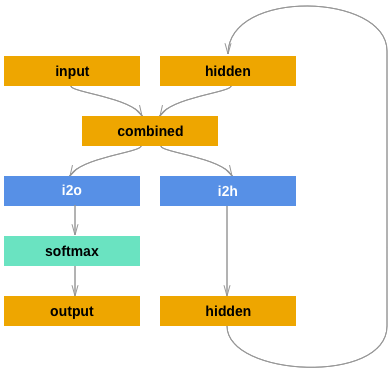

In [137]:
import torch.nn as nn
from torch.autograd import Variable

In [197]:
num_layers = 1
class RNN(nn.Module):
    def __init__(self, input_size, num_layers, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                           batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input):
        h0 = Variable(torch.zeros(self.num_layers, input.size(0),
                                 self.hidden_size))
        c0 = Variable(torch.zeros(self.num_layers, input.size(0),
                                 self.hidden_size))
        output, (hn, cn) = self.lstm(input,(h0,c0))
        output = self.softmax(self.fc(output[:, -1, :]))
        return output, (hn, cn)

In [198]:
n_hidden = 128
rnn = RNN(n_letters, num_layers, n_hidden, n_categories)

PyTorch modules work on Variables and not on Tensors

Use `lineToTensor` instead of `letterToTensor` and slices for efficiency.

In [201]:
input = Variable(lineToTensor("Albert"))

In [202]:
print(type(input[0]))
print(type(input))
print(input.size())
print(input[0].size())

<class 'torch.autograd.variable.Variable'>
<class 'torch.autograd.variable.Variable'>
torch.Size([6, 1, 55])
torch.Size([1, 55])


In [203]:
output, next_hidden = rnn(input)
print(output)

Variable containing:

Columns 0 to 9 
-2.8645 -2.9025 -2.8898 -2.9639 -2.8641 -2.9147 -2.8385 -2.8589 -2.8229 -2.8752
-2.8849 -2.9086 -2.8994 -2.9328 -2.8780 -2.9176 -2.8429 -2.8542 -2.8338 -2.8836
-2.8678 -2.9031 -2.8951 -2.9515 -2.8816 -2.9151 -2.8384 -2.8564 -2.8336 -2.8661
-2.8583 -2.8984 -2.9040 -2.9510 -2.8716 -2.9199 -2.8524 -2.8426 -2.8478 -2.8738
-2.8764 -2.9188 -2.8996 -2.9314 -2.8634 -2.9153 -2.8524 -2.8497 -2.8452 -2.8751
-2.8746 -2.9181 -2.9014 -2.9398 -2.8660 -2.9177 -2.8433 -2.8577 -2.8386 -2.8667

Columns 10 to 17 
-2.9797 -2.8928 -2.9257 -2.8873 -2.8840 -2.8490 -2.9508 -2.8777
-2.9568 -2.8882 -2.9236 -2.8727 -2.8787 -2.8516 -2.9498 -2.8801
-2.9528 -2.8985 -2.9302 -2.8794 -2.8708 -2.8547 -2.9588 -2.8851
-2.9585 -2.8859 -2.9228 -2.8710 -2.8789 -2.8518 -2.9632 -2.8873
-2.9644 -2.8850 -2.9339 -2.8727 -2.8892 -2.8472 -2.9400 -2.8777
-2.9561 -2.8879 -2.9200 -2.8779 -2.8820 -2.8504 -2.9504 -2.8892
[torch.FloatTensor of size 6x18]



Outputs is `<batch_size x n_categories>` tensor, where every item in a row is the likelihood of a category for the particular word

## Training

Prepare a helper function to make meaning of the output of the network.

In [204]:
top_n, top_i = output.data.topk(1)

In [205]:
top_n, top_i

(
 -2.8229
 -2.8338
 -2.8336
 -2.8426
 -2.8452
 -2.8386
 [torch.FloatTensor of size 6x1], 
  8
  8
  8
  7
  8
  8
 [torch.LongTensor of size 6x1])

In [152]:
def categoryFromOutput(output):
    top_n, top_i = output.data.topk(1) # tensor out of Varaible with .data
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

In [153]:
print(categoryFromOutput(output))

('names\\Chinese', 1)


Generating training examples ( a name and its language).

In [154]:
import random

In [155]:
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

In [156]:
def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = Variable(torch.LongTensor(
        [all_categories.index(category)]))
    line_tensor = Variable(lineToTensor(line))
    return category, line, category_tensor, line_tensor

In [157]:
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print("category= ", category, "/ line= ", line)

category=  names\Scottish / line=  Crawford
category=  names\Dutch / line=  Segers
category=  names\German / line=  Sauber
category=  names\English / line=  Pine
category=  names\Korean / line=  Suk
category=  names\Italian / line=  Porto
category=  names\Irish / line=  Maciomhair
category=  names\Arabic / line=  Koury
category=  names\English / line=  Gaudin
category=  names\Italian / line=  Milano


In [162]:
print(category_tensor.size(), line_tensor.size())
print(category_tensor)
print(line_tensor[0])

torch.Size([1]) torch.Size([6, 1, 55])
Variable containing:
 9
[torch.LongTensor of size 1]

Variable containing:

Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     0     0     0     1

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 54 
    0     0     0
[torch.FloatTensor of size 1x55]



### Training the Network

In [161]:
# last layer of network is softmax so NLLLoss is a reasonable choice
criterion = nn.NLLLoss()

Each loop in training will:
* create the training example and target
* initialize the hidden layer
* feed the network one word
    * keep hidden state for next letter
* compare the final output and target
* compute gradients
* backpropagate
* return the output and loss

In [163]:
lr = 0.005

param = None

def train(category_tensor, line_tensor):
    # create a class hidden layer
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    # feed each letter to the network
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # Add parameters' gradients to their values, multiplied by learning rate
    for i in rnn.parameters():
        i.data.add_(-lr, i.grad.data)
        
    return output, loss.data[0]

In [164]:
import time
import math

In [170]:
n_iters = 100000
print_every = 5000
plot_every = 1000

In [166]:
current_loss = 0
all_losses = []

In [167]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" %(m, s)

In [171]:
start = time.time()

for iter in range(1, n_iter+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 11s) 3.0841 Kennedy / names\German ✗ (names\Scottish)
10000 10% (0m 23s) 1.5970 Araullo / names\Portuguese ✓
15000 15% (0m 38s) 1.2530 Garofalo / names\Italian ✓
20000 20% (0m 52s) 1.2469 Kitoaji / names\Japanese ✓
25000 25% (1m 7s) 0.7913 Nonomura / names\Japanese ✓
30000 30% (1m 22s) 1.1341 Chin / names\Korean ✓
35000 35% (1m 36s) 0.2535 Bahar / names\Arabic ✓
40000 40% (1m 51s) 1.0719 Lawerenz / names\German ✓
45000 45% (2m 5s) 0.7167 Dufour / names\French ✓
50000 50% (2m 20s) 0.8619 Masi / names\Italian ✓
55000 55% (2m 34s) 1.4396 Jian / names\Chinese ✓
60000 60% (2m 49s) 1.0764 Ibu / names\Japanese ✓
65000 65% (3m 4s) 3.3067 Abbracciabene / names\Scottish ✗ (names\Italian)
70000 70% (3m 18s) 0.4027 Bagryansky / names\Russian ✓
75000 75% (3m 33s) 2.6016 Picasso / names\Italian ✗ (names\Spanish)
80000 80% (3m 47s) 0.9987 Melo / names\Portuguese ✓
85000 85% (4m 2s) 1.0921 Oldland / names\English ✓
90000 90% (4m 17s) 1.7606 Lapointe / names\Italian ✗ (names\French)
95000 9

In [174]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

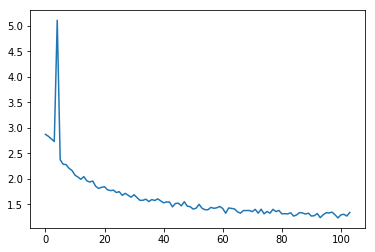

In [175]:
plt.figure()
plt.plot(all_losses)

### Evaluating the Results

Create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns).

To compute the confusion matrix a bunch of samples in eval() mode, which is same as train() mode minus the backprop.

In [176]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

In [177]:
def evaluate(line_tensor):
    hidden = rnn.initHidden()
    rnn.eval()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    rnn.train()
    return output

In [178]:
# Go through a bunch of examples and record which are correctly guessed

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

In [192]:
print(confusion.size())
print(confusion[0])

torch.Size([18, 18])

 261
  10
   2
  30
   0
   7
  36
  33
  46
  32
  53
  21
   3
  21
  25
  15
   3
   0
[torch.FloatTensor of size 18]



In [193]:
# Normalize each row by dividing every row by its sum
# essentially normalize across all the guess made by RNN for one row

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

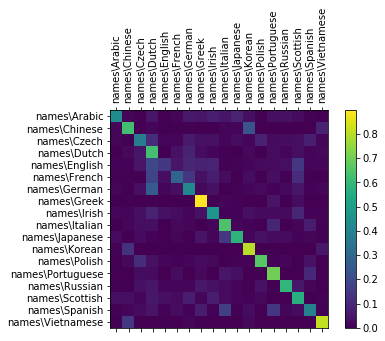

In [195]:
# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages)

## Running on User Input

In [196]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(lineToTensor(input_line)))

    # Get top N categories
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []

    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.87) names\Russian
(-1.33) names\Czech
(-2.20) names\English

> Jackson
(-0.20) names\Scottish
(-2.56) names\English
(-3.22) names\Dutch

> Satoshi
(-0.52) names\Italian
(-2.06) names\Japanese
(-3.11) names\Polish
